# Intro Task, Object Localization

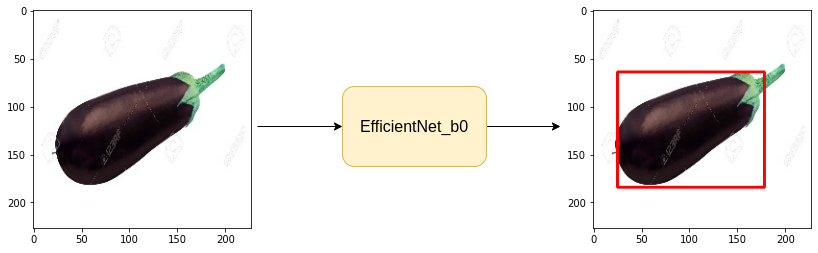

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [149]:
dataDir = 'object-localization-dataset/'
trainCSV = 'object-localization-dataset/train_images/train.csv'
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 25
image_size = 140
LR = 0.001
epochs = 100
MODEL_NAME = 'efficientnet_b0'
NO_COR = 4

In [150]:
df = pd.read_csv("object-localization-dataset/train.csv")



# Understand the dataset

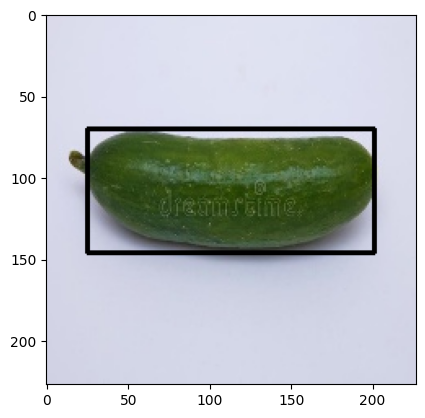

In [151]:
row = df.iloc[20]
img = cv2.imread(dataDir+row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin,row.ymin)
pt2 = (row.xmax,row.ymax)
dBoxImg=cv2.rectangle(img, pt1, pt2,(0,0,0),2)
plt.imshow(dBoxImg)

In [152]:
trainDf,validDf = train_test_split(df,test_size=0.2, random_state=41)

In [153]:
len(validDf)

38

# Augmentations

In [154]:
import albumentations as A

In [155]:
train_aug = A.Compose([
    A.Resize(image_size,image_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
valid_augs = A.Compose([
    A.Resize(image_size,image_size),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [156]:
class ObjLocDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentation=None):
        self.df =df
        self.augmentation = augmentation
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        xmax= row.xmax
        xmin = row.xmin
        ymax = row.ymax
        ymin = row.ymin
        bbox = [[xmin, ymin, xmax, ymax]]

        imgPath=dataDir + row.img_path
        img = cv2.imread(imgPath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.augmentation:
            data = self.augmentation(image=img,bboxes=bbox, class_labels= [None])
            img = data['image']
            bbox = data['bboxes'][0]
        
        img = torch.from_numpy(img).permute(2,0,1)/255.0
        bbox = torch.tensor(bbox, dtype=torch.float32)
        return img , bbox

In [157]:

trainset = ObjLocDataset(trainDf, train_aug)
validset = ObjLocDataset(validDf, valid_augs)

In [158]:
len(validset)

38

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


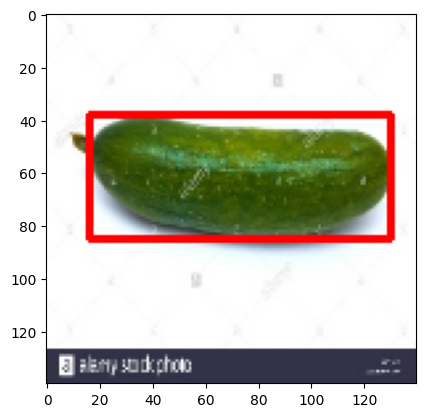

In [159]:
img, bbox = trainset[6]
xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [160]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 32, shuffle = True)
validloader = torch.utils.data.DataLoader(validset,batch_size = 32, shuffle = False)

In [161]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 5
Total no. batches in validloader : 2


In [162]:

for images, bboxes in trainloader:
    break

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([32, 3, 140, 140])
Shape of one batch bboxes : torch.Size([32, 4])


# Create Model

In [163]:
from torch import nn
import timm

In [176]:

class ObjlocModel(nn.Module):
    def __init__(self):
        super(ObjlocModel, self).__init__()
        self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)
    
    def forward(self, images, gt_bboxes=None):
        bboxes = self.backbone(images)
        if gt_bboxes!= None:
            loss = nn.MSELoss()(bboxes,gt_bboxes)
            return bboxes, loss
        return bboxes

In [ ]:
model = ObjlocModel()
model.to(device)

In [178]:
ran = torch.rand(1,3,140,140).to(device)
model(ran).shape


torch.Size([1, 4])

# Create Train and Eval Function

In [183]:

def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train()
    for data in tqdm(dataloader):
        images, gt_bboxes = data
        images, gt_bboxes = images.to(device), gt_bboxes.to(device)

        bboxes, loss = model(images, gt_bboxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss+= loss.item()
    return total_loss/len(dataloader)

In [187]:

def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval()
    with torch.no_grad():
        for data in tqdm(dataloader):
            images, gt_bboxes = data
            images, gt_bboxes = images.to(device), gt_bboxes.to(device)
    
            bboxes, loss = model(images, gt_bboxes)
            total_loss+= loss.item()
    return total_loss/len(dataloader)

#Training Loop

In [188]:
optimizer = torch.optim.Adam(model.parameters(), lr =LR)

In [190]:
best_valid_loss = np.Inf
for i in range(epochs):
    train_loss=train_fn(model, trainloader, optimizer)
    valid_loss=eval_fn(model, validloader)
    if valid_loss< best_valid_loss:
        torch.save(model.state_dict(),"best_model.pt")
        print("Saved something new")
        best_valid_loss = valid_loss
    print(f"Epoch : {i+1} train loss:  {train_loss} valid loss:{valid_loss}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 1 train loss:  1708.51796875 valid loss:8304.65234375


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 2 train loss:  1246.745556640625 valid loss:1846.0658569335938


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 3 train loss:  1000.4683837890625 valid loss:864.785888671875


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 4 train loss:  776.0704711914062 valid loss:378.40245056152344


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 5 train loss:  667.2248291015625 valid loss:258.6809387207031


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 6 train loss:  493.375048828125 valid loss:178.37139129638672


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 7 train loss:  416.9291625976563 valid loss:123.67322540283203


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 8 train loss:  362.0368713378906 valid loss:112.49564361572266


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 9 train loss:  343.86988525390626 valid loss:157.9414291381836


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 10 train loss:  313.6077362060547 valid loss:123.14924621582031


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 11 train loss:  240.99012145996093 valid loss:104.43666458129883


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 12 train loss:  206.25469665527345 valid loss:133.8539161682129


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 13 train loss:  176.21089782714844 valid loss:136.9917449951172


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 14 train loss:  170.84971313476564 valid loss:108.79204559326172


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 15 train loss:  142.22647705078126 valid loss:110.71152877807617


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 16 train loss:  120.52760162353516 valid loss:102.8615951538086


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 17 train loss:  91.52983245849609 valid loss:113.5288314819336


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 18 train loss:  87.27364044189453 valid loss:77.36743545532227


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 19 train loss:  74.68876495361329 valid loss:65.94643783569336


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 20 train loss:  75.40337677001953 valid loss:63.213104248046875


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 21 train loss:  66.31596298217774 valid loss:69.37874412536621


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 22 train loss:  63.608743286132814 valid loss:85.81967544555664


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 23 train loss:  52.514137268066406 valid loss:71.60134887695312


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 24 train loss:  47.747886657714844 valid loss:64.7552719116211


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 25 train loss:  42.49684371948242 valid loss:64.2351303100586


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 26 train loss:  47.050733184814455 valid loss:75.23805618286133


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 27 train loss:  37.63918228149414 valid loss:72.58371353149414


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 28 train loss:  38.48684387207031 valid loss:66.80537414550781


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 29 train loss:  45.938653564453126 valid loss:59.4049186706543


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 30 train loss:  45.4800537109375 valid loss:53.66072654724121


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 31 train loss:  42.949833679199216 valid loss:46.875539779663086


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 32 train loss:  41.15125846862793 valid loss:52.37053680419922


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 33 train loss:  33.1531005859375 valid loss:64.3139762878418


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 34 train loss:  35.2304084777832 valid loss:55.67524337768555


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 35 train loss:  32.62779159545899 valid loss:56.05025291442871


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 36 train loss:  41.87809677124024 valid loss:68.73814392089844


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 37 train loss:  29.99077949523926 valid loss:52.58530616760254


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 38 train loss:  39.4990478515625 valid loss:52.664913177490234


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 39 train loss:  26.651560592651368 valid loss:47.13209915161133


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 40 train loss:  26.434870147705077 valid loss:49.26771926879883


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 41 train loss:  28.73721809387207 valid loss:42.54199028015137


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 42 train loss:  26.567718505859375 valid loss:46.09903144836426


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 43 train loss:  26.806237411499023 valid loss:42.890380859375


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 44 train loss:  31.319942474365234 valid loss:35.89436912536621


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 45 train loss:  32.37223358154297 valid loss:42.57047080993652


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 46 train loss:  25.26836738586426 valid loss:45.2041015625


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 47 train loss:  26.94286003112793 valid loss:52.26314735412598


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 48 train loss:  24.52353744506836 valid loss:44.18392753601074


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 49 train loss:  26.16990795135498 valid loss:38.37665557861328


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 50 train loss:  23.90818099975586 valid loss:32.95727729797363


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 51 train loss:  21.616811752319336 valid loss:34.888545989990234


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 52 train loss:  21.78701171875 valid loss:44.75662422180176


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 53 train loss:  27.41686019897461 valid loss:40.250566482543945


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 54 train loss:  21.961680603027343 valid loss:43.193227767944336


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 55 train loss:  25.242519187927247 valid loss:39.79738807678223


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 56 train loss:  22.37770233154297 valid loss:33.42707538604736


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 57 train loss:  18.25114574432373 valid loss:39.500600814819336


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 58 train loss:  21.68478469848633 valid loss:50.87886047363281


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 59 train loss:  23.044395446777344 valid loss:46.987518310546875


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 60 train loss:  18.52709674835205 valid loss:41.179229736328125


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 61 train loss:  16.137724685668946 valid loss:50.28023910522461


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 62 train loss:  26.915678024291992 valid loss:49.64501953125


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 63 train loss:  16.70066146850586 valid loss:46.59572982788086


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 64 train loss:  23.438863372802736 valid loss:38.86020851135254


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 65 train loss:  17.240043449401856 valid loss:46.70915985107422


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 66 train loss:  22.569994735717774 valid loss:42.4632625579834


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 67 train loss:  26.175569534301758 valid loss:47.66228485107422


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 68 train loss:  16.17045192718506 valid loss:62.37118339538574


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 69 train loss:  18.2171911239624 valid loss:53.1827507019043


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 70 train loss:  22.324592208862306 valid loss:44.27570915222168


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 71 train loss:  19.92978401184082 valid loss:45.022186279296875


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 72 train loss:  18.99827346801758 valid loss:45.585710525512695


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 73 train loss:  21.594441223144532 valid loss:45.1061897277832


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 74 train loss:  19.695784187316896 valid loss:38.544681549072266


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 75 train loss:  21.357842254638673 valid loss:37.783761978149414


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 76 train loss:  22.926982879638672 valid loss:40.194868087768555


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 77 train loss:  19.87038650512695 valid loss:35.91849708557129


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 78 train loss:  16.99687080383301 valid loss:38.57071113586426


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 79 train loss:  24.74673843383789 valid loss:37.11404609680176


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 80 train loss:  28.469074630737303 valid loss:40.08453178405762


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 81 train loss:  16.808145141601564 valid loss:48.56793403625488


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 82 train loss:  17.312161254882813 valid loss:51.39773178100586


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 83 train loss:  12.843101692199706 valid loss:42.124990463256836


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 84 train loss:  19.983122253417967 valid loss:45.05250930786133


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 85 train loss:  25.47967872619629 valid loss:36.848562240600586


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 86 train loss:  14.950039482116699 valid loss:34.04003143310547


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 87 train loss:  26.17652587890625 valid loss:43.29399871826172


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 88 train loss:  22.175003433227538 valid loss:45.137020111083984


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 89 train loss:  22.337214279174805 valid loss:48.5026798248291


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 90 train loss:  15.382270622253419 valid loss:43.67314910888672


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 91 train loss:  24.68308029174805 valid loss:51.7998046875


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved something new
Epoch : 92 train loss:  25.90483169555664 valid loss:30.4039363861084


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 93 train loss:  18.09135684967041 valid loss:31.948429107666016


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 94 train loss:  20.844642639160156 valid loss:39.6306037902832


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 95 train loss:  17.072202682495117 valid loss:43.26999282836914


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 96 train loss:  19.432463073730467 valid loss:39.6837100982666


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 97 train loss:  15.896222591400146 valid loss:32.998642921447754


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 98 train loss:  16.436420822143553 valid loss:41.42569541931152


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 99 train loss:  12.760580825805665 valid loss:33.78674125671387


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 100 train loss:  19.21753692626953 valid loss:36.64860534667969


#Inference

In [196]:
execfile("object-localization-dataset/utils.py")

In [193]:
import /object-localization-dataset/utils

SyntaxError: invalid syntax (560741449.py, line 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


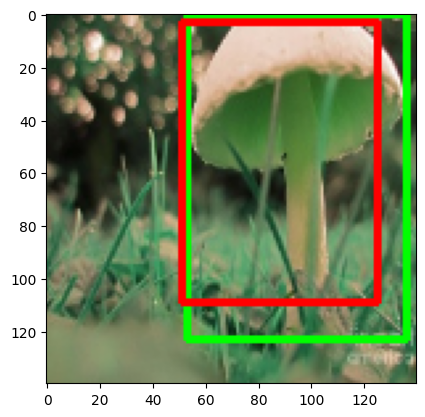

In [201]:

model.load_state_dict(torch.load("best_model.pt"))
model.eval()

with torch.no_grad():
    image, gt_bbox = validset[25]
    image = image.unsqueeze(0).to(device)
    out_bbox = model(image)
    execfile("object-localization-dataset/utils.py")
    compare_plots(image, gt_bbox, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya